In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unrar x '/content/drive/My Drive/COMP4211/data.rar'

Mounted at /content/drive

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/My Drive/COMP4211/data.rar

Creating    data                                                      OK
Extracting  data/meta.csv                                                  0%  OK 
Extracting  data/NASDAQ.csv                                                0%  OK 
Extracting  data/NASDAQ_preprocess.csv                                     0%  OK 
Extracting  data/onehot_encoder.pkl                                        0%  OK 
Creating    data/price                                                OK
Extracting  data/price/AACG.csv                                            0%  OK 
Extracting  data/price/AACI.csv                                            0%  OK 
Extracting  data/price/AACIW.csv                                           0%  OK 
Extracting  data/price/AAGR.csv                  

In [2]:
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.layers import Concatenate,Embedding ,Dense ,Input,LSTM,Permute,Softmax,Lambda,Flatten,GRU,Dropout,BatchNormalization, Normalization, Attention, Bidirectional, Masking
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import F1Score, Accuracy
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow.keras.losses import BinaryCrossentropy
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import h5py
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
class DataGenerator(Sequence):

    def __init__(self, meta_df, batch_size=64, use_full=False, input_shape=(20,196), **kwargs):
        super().__init__(**kwargs)
        self.ds_pointer = 0
        self.batch_size = batch_size
        self.use_full = use_full
        self.meta_df = meta_df
        self.data = self.load_file()
        self.input_buffer = np.zeros((batch_size,input_shape[0],input_shape[1]))
        self.label_buffer = np.zeros((batch_size,1))
        self.reset_pointer()

    def load_file(self):
        result = {}
        for root, _, files in os.walk('data/train_data'):
            for file in files:
                if f'.h5' in file:
                    symbol = file.split('.')[0]
                    df = pd.read_csv(f'data/price/{symbol}.csv')
                    result[symbol] = h5py.File(f'data/train_data/{symbol}.h5', 'r', rdcc_nbytes=100*1024**2, rdcc_nslots=1e4)
        return result

    def reset_pointer(self, seed = 1314):
        self.meta_df = self.meta_df.sample(frac=1, random_state=seed)
        self.ds_pointer = 0

    def __len__(self):
        if self.use_full:
            return len(self.meta_df)// self.batch_size
        else:
            return len(self.meta_df)// self.batch_size// 10

    def num_labels(self):
        return len(self.label_name)

    def __getitem__(self, index):
        import os
        import numpy as np
        if self.ds_pointer + self.batch_size >= len(self.meta_df):
            self.reset_pointer()
            return self.__getitem__(index)
        to_get = self.meta_df.iloc[self.ds_pointer:self.ds_pointer+ self.batch_size]
        to_get_index = to_get['Index'].to_numpy()
        to_get_symbol = to_get['Symbol'].to_numpy()

        for i, symbol in enumerate(to_get_symbol):
            to_fetch = self.data[symbol]
            self.input_buffer[i, :, :] = to_fetch['data'][to_get_index[i]]
            self.label_buffer[i] = to_fetch['label'][to_get_index[i]]

        batch_x = self.input_buffer
        batch_y = self.label_buffer

        self.ds_pointer+=self.batch_size
        return batch_x, batch_y

In [74]:

def build_model(time_series,num_of_features):
    K.clear_session()
    input_ = Input(shape=(time_series,num_of_features), name='Input')
    input_dense = Dense(256)(input_)

    # Define GRU layer
    encoder = GRU(256, return_state=True, return_sequences=True, name='Encoder')
    encoder_outputs, state_h = encoder(input_dense)

    # # Define attention layer
    attention = Attention(name='Attention')
    context_vector = attention([encoder_outputs, encoder_outputs])

    # Concatenate context vector and encoder outputs
    concat_layer = Concatenate(axis=-1, name='Concatenate')
    decoder_combined_context = concat_layer([context_vector, input_dense])

    # Define decoder
    decoder_gru = GRU(256, return_sequences=True, name='Decoder')

    # Pass the concatenated input through the decoder
    decoder_output = decoder_gru(decoder_combined_context, initial_state=state_h)

    output = Flatten(name='Flatten')(decoder_output)
    output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(256,activation="relu")(output)
    output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(1, activation='sigmoid')(output)


    model = Model(inputs = input_ , outputs = output)
    adam_optimizer = Adam(learning_rate=0.0005, clipnorm=1., clipvalue=0.5, weight_decay=1e-7)
    model.compile(loss="binary_crossentropy",optimizer=adam_optimizer,metrics=['accuracy'])
    model.summary()
    return model


In [17]:
def build_model(time_series,num_of_features):
    K.clear_session()
    input_ = Input(shape=(time_series,num_of_features), name='Input')

    encoder = GRU(64, return_state=True, return_sequences=True, name='Encoder')
    encoder_outputs, state_h = encoder(input_)

    output = Flatten(name='Flatten')(encoder_outputs)
    # output = Dense(128, activation='relu')(output)
    # output = Dropout(0.5)(output)
    # output = BatchNormalization()(output)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs = input_ , outputs = output)
    adam_optimizer = Adam(learning_rate=0.00001)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['binary_accuracy',tfa.metrics.F1Score(1,average='weighted')])
    model.summary()
    return model

In [5]:
# Model Config
batch_size = 64
time_series = 20
input_shape = (time_series,6)
num_features=input_shape[1]

meta_df = pd.read_csv('data/meta.csv',index_col=0)
train_meta, test_meta = train_test_split(meta_df, test_size=0.2, random_state=4211)
# display(train_meta)
# display(test_meta)
train_generator = DataGenerator(train_meta,input_shape=input_shape, batch_size=batch_size)
val_generator = DataGenerator(test_meta,input_shape=input_shape, batch_size=batch_size)

In [18]:

# Directory Config
neural_path = 'neural_network'
save_path_dir='attention_t20_fullFeatures_encode_decode'

if not os.path.exists(f'{neural_path}/{save_path_dir}'):
    os.makedirs(f'{neural_path}/{save_path_dir}')

checkpoint = ModelCheckpoint(
    f'{neural_path}/{save_path_dir}/saved_model.keras',
    verbose=1,
    monitor='val_f1_score',
    save_weights_only=False,
    save_best_only=True,
    mode='max')

earlystop = EarlyStopping(
    monitor="val_f1_score",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

model = build_model(time_series,num_features)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20, 6)]           0         
                                                                 
 Encoder (GRU)               [(None, 20, 64),          13824     
                              (None, 64)]                        
                                                                 
 Flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 15105 (59.00 KB)
Trainable params: 15105 (59.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Epoch 1/2000
161/161 [==============================] - ETA: 0s - loss: 0.6857 - binary_accuracy: 0.5706 - f1_score: 0.5561
Epoch 1: val_f1_score improved from -inf to 0.55040, saving model to neural_network/attention_t20_fullFeatures_encode_decode/saved_model.keras
161/161 [==============================] - 14s 72ms/step - loss: 0.6857 - binary_accuracy: 0.5706 - f1_score: 0.5561 - val_loss: 0.6840 - val_binary_accuracy: 0.5934 - val_f1_score: 0.5504
Epoch 2/2000
160/161 [============================>.] - ETA: 0s - loss: 0.6832 - binary_accuracy: 0.5917 - f1_score: 0.5670
Epoch 2: val_f1_score improved from 0.55040 to 0.57896, saving model to neural_network/attention_t20_fullFeatures_encode_decode/saved_model.keras
161/161 [==============================] - 10s 64ms/step - loss: 0.6832 - binary_accuracy: 0.5920 - f1_score: 0.5668 - val_loss: 0.6841 - val_binary_accuracy: 0.5863 - val_f1_score: 0.5790
Epoch 3/2000
160/161 [============================>.] - ETA: 0s - loss: 0.6766 - bina

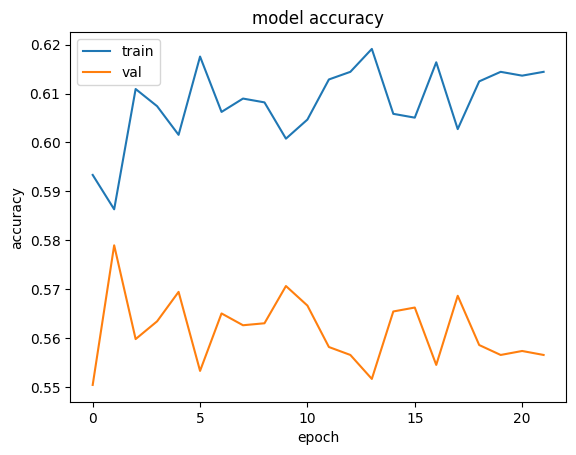

Highest Val Accuracy: 0.619140625
Highest Val F1: 0.5789620280265808


In [19]:
history = model.fit(train_generator, batch_size=batch_size, epochs=2000, validation_data=val_generator, callbacks=[checkpoint, earlystop])
plt.plot(history.history['val_binary_accuracy'])
plt.plot(history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print(f"Highest Val Accuracy: {max(history.history['val_binary_accuracy'])}")
print(f"Highest Val F1: {max(history.history['val_f1_score'])}")